### Import Libs and Change WD:

Import the libraries we need, and also change the working directory to the directory containing the PartNet dataset.

In [1]:
from pathlib import Path
import os
import json
import shutil
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from multiprocessing import Pool
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'svg'

# Use pathlib
current_dir = Path.cwd()
target_dir = Path('/srv/healthcare/datascience/data/part-net')

print(f'Current Working Directory: {current_dir}')
if current_dir != target_dir:
    print('Changing directory')
    os.chdir(target_dir)
    print(f'New Working directory: {Path.cwd()}')


Current Working Directory: /home/toy-problem/notebooks
Changing directory
New Working directory: /srv/healthcare/datascience/data/part-net


### Count Unique Samples:

We would like to get some insight into the data distribution, therefore extract the number of samples per class.

Loading errors: 1


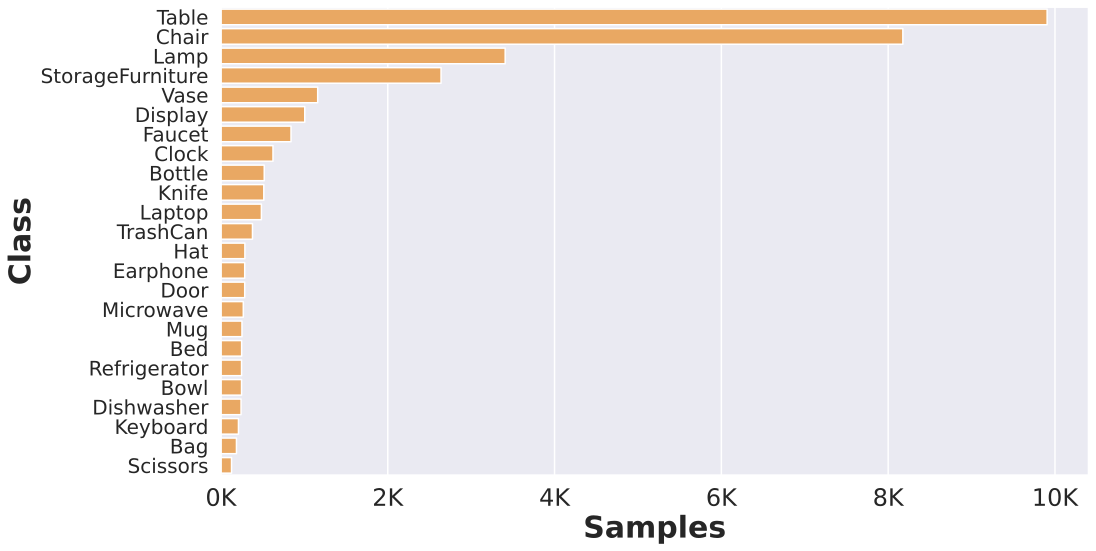

In [4]:
import matplotlib.ticker as ticker

def process_sample(sample):
    """
    Process a single sample, loading its class information.

    :param sample: The sample directory name.
    :return: A tuple containing the class name and count.
    """
    meta_data_path = Path(f'data_v0/{sample}/meta.json')
    try:
        with open(meta_data_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            class_name = data['model_cat']
            return (class_name, 1)
    except:
        return ('_error', 1)

with Pool() as pool:
    results = pool.map(process_sample, os.listdir('data_v0'))

class_info = defaultdict(int)
loading_errors = 0

for class_name, count in results:
    if class_name == '_error':
        loading_errors += count
    else:
        class_info[class_name] += count

def plot_sample_dist(data):
    """
    Plot the class distribution in a visually appealing way.

    :param data: DataFrame containing the class and samples information.
    """
    plt.figure(figsize=(18, 8), dpi=300)
    sns.set(style='whitegrid', rc={'axes.facecolor':'#EAEAF2', 
                               'grid.color':'#FFFFFF', 
                               'axes.edgecolor':'#FFFFFF', 
                               'grid.linewidth': 2.5})  # Increase grid line width
    sns.set_context("talk")

    ax = sns.barplot(x='samples', y='class', data=data, color='#ffa94d')
    ax.set_xlabel('Samples', fontsize=30, weight='bold')
    ax.set_ylabel('Class', fontsize=30, weight='bold')
    ax.tick_params(axis='x', labelsize=24)
    ax.tick_params(axis='y', labelsize=20)

    # Format x-axis labels to be more readable
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x/1000)}K'))

    for spine in ax.spines.values():
        spine.set_visible(True)
        # spine.set_color('black')
        spine.set_linewidth(1.5)

    plt.tight_layout()  # Adjust the padding here
    plt.subplots_adjust(right=0.85)

    # Saving the plot
    plt.savefig("/../../../../../home/toy-problem/notebooks/img/partnet_data_dist.png")


print(f'Loading errors: {loading_errors}')

sorted_class_info = sorted(class_info.items(), key=lambda x: x[1], reverse=True)
df = pd.DataFrame(sorted_class_info, columns=['class', 'samples'])
plot_sample_dist(df)


### Create a new dataset consisting of only one class ###

In [2]:
def get_class(sample):
    meta_data_path = os.path.join('data_v0', sample, 'meta.json')
    try:
        with open(meta_data_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
            return (sample, data['model_cat'])
    except:
        return None

def copy_sample(args):
    sample, target_dir = args
    src_dir = os.path.join('data_v0', sample)
    dst_dir = os.path.join(target_dir, sample)
    shutil.copytree(src_dir, dst_dir)

def copy_samples_of_class(target_class, target_dir):
    with Pool() as pool:
        # Get the class of each sample
        sample_classes = pool.map(get_class, os.listdir('data_v0'))

        # Filter out None values before unpacking
        sample_classes = [sc for sc in sample_classes if sc is not None]
        
        # Filter to get the samples of the target class
        target_samples = [sample for sample, class_ in sample_classes if class_ == target_class]
        
        # Copy the target samples to the target directory
        pool.map(copy_sample, [(sample, target_dir) for sample in target_samples])

# Specify the class you're interested in and the directory to copy to
target_class = 'Table'
target_dir = 'data_tbl_v0'

# Call the function to copy the samples
if os.path.exists(target_dir):
    print(f'the folder {target_dir} already exists.')
else:
    copy_samples_of_class(target_class, target_dir)


### Remove the unimportant files from a dataset

After creating the single class datasets, I noticed some files are redundent. 

| Filename                           | Description                                                         |
|------------------------------------|---------------------------------------------------------------------|
| `result.json`                      | JSON storing part hierarchical trees from raw user annotation       |
| `result_after_merging.json`        | JSON storing part hierarchical trees post semantics merging (final) |
| `meta.json`                        | JSON storing all related meta-information                           |
| `tree_hier.html`                   | HTML visualization for hierarchical annotation (pre-merging)         |
| `tree_hier_after_merging.html`     | HTML visualization for hierarchical annotation (post-merging)        |

### Directories and Their Contents:

- **objs/**: Contains part obj files indexed by `result.json`. Note:
    - Parts here are not final; refer to `result.json`.
    - Individual obj files might not make sense in isolation.
    - Files prefixed with `original-` are from the original ShapeNet model.
    - Files prefixed with `new-` are smoothed/cut-out in PartNet annotation procedure.

- **part_renders/** and **part_renders_after_merging/**:
    - Contain rendered images supporting respective HTML visualizations.

- **point_sample/**: Contains data for point cloud learning.
    - `pts-10000.txt`: Point cloud sampled from the combination of part meshes under `objs/`.
    - `label-10000.txt`: Labels are the id in `result.json`.
    - `sample-points-all-pts-nor-rgba-10000.txt`: Point cloud from whole ShapeNet model with labels transferred from `label-10000.txt`.
    - `sample-points-all-label-10000.txt`: Labels propagated to `sample-points-all-pts-nor-rgba-10000.txt`.

### Notes:

- Files labeled "after_merging" are final data files and should be prioritized for use.
- Object files in the `objs/` directory are not important for our purposes and have been omitted.


In [4]:
to_remove = ['tree_hier.html', 'objs/', 'objs-normalized-as-shapenetv1/', 
             'parts_render/', 'point_sample/ply-10000.ply', 'point_sample/pts-10000.pts', 
             'point_sample/label-10000.txt', 'point_sample/pts-10000.txt']
dataset = 'data_table'

In [5]:
def remove_items(root_dir: str, items_to_remove: list):
    for sub_dir_name in tqdm(os.listdir(root_dir), desc="Processing subdirectories"):
        sub_dir_path = os.path.join(root_dir, sub_dir_name)
        if os.path.isdir(sub_dir_path):
            for item in items_to_remove:
                item_path = os.path.join(sub_dir_path, item)
                if os.path.exists(item_path):
                    try:
                        if os.path.isdir(item_path):
                            shutil.rmtree(item_path)
                        else:
                            os.remove(item_path)
                    except Exception as e:
                        print(f"Error removing {item_path}: {e}")

# Usage
dataset_dir = os.path.join(os.getcwd(), dataset)  # Assuming 'dataset' is the folder name
remove_items(dataset_dir, to_remove)

Processing subdirectories:   0%|          | 0/9906 [00:00<?, ?it/s]

### Now we are left with the following files for each sample:

| Filename                           | Description                                                         |
|------------------------------------|---------------------------------------------------------------------|
| `result.json`                      | JSON storing part hierarchical trees from raw user annotation       |
| `result_after_merging.json`        | JSON storing part hierarchical trees post semantics merging (final) |
| `meta.json`                        | JSON storing all related meta-information                           |
| `tree_hier_after_merging.html`     | HTML visualization for hierarchical annotation (post-merging)        |

### Directories and Their Contents:

- **part_renders_after_merging/**:
    - Contains rendered images supporting the HTML visualization post-merging.

- **point_sample/**: Contains data for point cloud learning (except removed files).
    - `sample-points-all-pts-nor-rgba-10000.txt`: Point cloud from whole ShapeNet model with labels transferred.
    - `sample-points-all-label-10000.txt`: Labels propagated to `sample-points-all-pts-nor-rgba-10000.txt`.